# NPG primal-dual comparison for finite constrained MDPs (conservative)

In [1]:
'''
Set-up:
1) Softmax policy 
2) Bounded rewards
3) Many states and actions
4) (Natural) policy gradient + primal-dual method
   Regularized (Natural) policy gradient + primal-dual method
   (Natural) policy gradient + optimistic primal-dual method
   (Natural) policy gradient + PID primal-dual method
   
References:
1) NPG primal-dual   
   Natural policy gradient primal-dual method for constrained Markov decision processes
   https://proceedings.neurips.cc/paper_files/paper/2020/file/5f7695debd8cde8db5abcb9f161b49ea-Paper.pdf
2) NPG PID primal-dual method
   Responsive Safety in Reinforcement Learning by PID Lagrangian Methods
   https://arxiv.org/abs/2007.03964
'''

'\nSet-up:\n1) Softmax policy \n2) Bounded rewards\n3) Many states and actions\n4) (Natural) policy gradient + primal-dual method\n   Regularized (Natural) policy gradient + primal-dual method\n   (Natural) policy gradient + optimistic primal-dual method\n   (Natural) policy gradient + PID primal-dual method\n   \nReferences:\n1) NPG primal-dual   \n   Natural policy gradient primal-dual method for constrained Markov decision processes\n   https://proceedings.neurips.cc/paper_files/paper/2020/file/5f7695debd8cde8db5abcb9f161b49ea-Paper.pdf\n2) NPG PID primal-dual method\n   Responsive Safety in Reinforcement Learning by PID Lagrangian Methods\n   https://arxiv.org/abs/2007.03964\n'

In [2]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [3]:
## Random Seed
np.random.seed(10) 
## Problem Setup
gamma = 0.9
n, m = 20, 5 # s, a
'''
Randomly generated probability transition matrix P((s,a) -> s') in R^{|S||A| x |S|}
Each row sums up to one
'''
raw_transition = np.random.uniform(0,1,size=(n*m,n))
prob_transition = raw_transition/raw_transition.sum(axis=1,keepdims=1)
'''
Random positive rewards
'''
reward = np.random.uniform(0,1,size=(n*m))

'''
Random utilities between -1 and +1
'''
utility = np.random.uniform(-1,1,size=(n*m))

'''
Start state distribution
'''
# uniform
rho = np.ones(n)/n

In [4]:
'''
Input: theta as an array and 
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        for j in range(m*i,m*(i+1)):
            prob.append(np.exp(theta[j])/norm)
            
    return np.asarray(prob)

In [5]:
'''
Input: theta as an array and 
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy_naive(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(theta[m*i:m*(i+1)])
        for j in range(m*i,m*(i+1)):
            prob.append(theta[j]/norm)
            
    return np.asarray(prob)

In [6]:
"""
License: BSD
Author: Mathieu Blondel
Implements three algorithms for projecting a vector onto the simplex: sort, pivot and bisection.
For details and references, see the following paper:
Large-scale Multiclass Support Vector Machine Training via Euclidean Projection onto the Simplex
Mathieu Blondel, Akinori Fujino, and Naonori Ueda.
ICPR 2014.
http://www.mblondel.org/publications/mblondel-icpr2014.pdf
"""

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_bisection(v, z=1, tau=0.0001, max_iter=1000):
    func = lambda x: np.sum(np.maximum(v - x, 0)) - z
    lower = np.min(v) - z / len(v)
    upper = np.max(v)

    for it in range(max_iter):
        midpoint = (upper + lower) / 2.0
        value = func(midpoint)

        if abs(value) <= tau:
            break

        if value <= 0:
            upper = midpoint
        else:
            lower = midpoint

    return np.maximum(v - midpoint, 0)

In [7]:
'''
Input: theta as an array and 
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def project_to_policy(theta,n,m):
    prob = []
    prob_pers = []
    for i in range(n):
#         norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        prob_pers = projection_simplex_sort(theta[m*i:m*(i+1)], z=1)
        for j in range(m):
            prob.append(prob_pers[j])
            
    return np.asarray(prob)

In [8]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|S| x |S||A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n,n*m))
    for i in range(n):
        Pi[i,i*m:(i+1)*m] = prob[i*m:(i+1)*m]
    
    return Pi

In [9]:
'''
Input: probability vector, state, action
Output: \nabla_{\theta} \pi_{\theta}(s,a)

States go from 0 to n-1 and actons from 0 to m-1
'''
def grad_state_action(prob,state,action):
    grad = np.zeros(n*m)
    for j in range(0,m):
        if j == action:
            grad[m*state + j] = prob[m*state + j]*(1-prob[m*state + j])
        else:
            grad[m*state + j] = -prob[m*state + action]*prob[m*state + j]
            
    return grad

def grad_state(qvals,prob,state):
    grad = np.sum([qvals[state*m + i]*grad_state_action(prob,state,i) for i in range(0,m)],axis=0)
    return grad

def grad(qvals,prob,d_pi):
    grad = np.sum([d_pi[i]*grad_state(qvals,prob,i) for i in range(0,n)],axis=0)
    return grad

In [10]:
'''
Input: probability vector
Output: Fisher information matrix
        \nabla_{\theta} \pi_{\theta}(s,a) x {\nabla_{\theta} \pi_{\theta}(s,a)}^T
'''
def Fisher_info(prob,d_pi):
    qvals_one = np.ones(n*m)
    grad = np.sum([d_pi[i]*grad_state(qvals_one,prob,i) for i in range(0,n)],axis=0)
    fisher = np.outer(grad,grad)+1e-3*np.identity(n*m)
    return fisher

In [11]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])
    
    ell = np.dot(V,rho)
    return ell

In [12]:
'''
The overall reward advantage function \ell(\theta)
'''
def avals(qvals,prob):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])
    
    A = qvals
    for i in range(n):
        for j in range(m):
            A[i*m + j] = qvals[i*m + j] - V[i]
        
    return A

In [13]:
'''
The projection function
Input: a scalar 
Output: a scalar in the interval [0 C]
'''
def proj(scalar,gamma):
    offset = 1000/(1-gamma)
    if scalar < 0:
        scalar = 0

    if scalar > offset:
        scalar = offset

    return scalar

## Policy Iteration to check feasibility 

In [14]:
raw_vec = np.random.uniform(0,1,size=(n,m))
prob_vec = raw_vec/raw_vec.sum(axis=1,keepdims=1)
init_policy = prob_vec.flatten()## Policy Iteration to get the optimal policy

In [15]:
'''
Policy iteration function
'''
def policy_iter(q_vals,n,m):
    new_policy = np.zeros(n*m)
    for i in range(n):
        idx = np.argmax(q_vals[i*m:(i+1)*m])
        new_policy[i*m + idx] = 1
    
    return new_policy       

In [16]:
curr_policy = np.random.uniform(0,1,size=(n*m))
new_policy = init_policy
print('Starting policy',init_policy)

while np.count_nonzero(curr_policy - new_policy) > 0:
    curr_policy = new_policy
    Pi = get_Pi(curr_policy,n,m)
    mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
    q_vals_utility = np.dot(np.linalg.inv(mat),utility)
    new_policy = policy_iter(q_vals_utility,n,m)
    
# print('Final policy',new_policy)
    

Starting policy [0.022861 0.022257 0.496791 0.417151 0.040940 0.260055 0.020741 0.239421
 0.113255 0.366528 0.077009 0.252897 0.293405 0.147306 0.229383 0.234235
 0.114754 0.214643 0.266094 0.170273 0.019934 0.289380 0.444991 0.163370
 0.082325 0.184145 0.550146 0.115828 0.008301 0.141579 0.193071 0.128147
 0.056816 0.408135 0.213831 0.164747 0.271480 0.219975 0.227132 0.116667
 0.170695 0.097732 0.193326 0.297322 0.240925 0.204368 0.076399 0.025505
 0.397828 0.295900 0.232097 0.206203 0.026091 0.237565 0.298044 0.098219
 0.185154 0.083181 0.392678 0.240769 0.392924 0.090288 0.311557 0.079063
 0.126168 0.106657 0.096738 0.356238 0.324030 0.116337 0.184156 0.268226
 0.030368 0.122968 0.394283 0.506945 0.038054 0.101757 0.114022 0.239222
 0.075823 0.464715 0.061802 0.241150 0.156510 0.268392 0.088919 0.131564
 0.277810 0.233316 0.377841 0.216636 0.191506 0.064988 0.149028 0.467008
 0.035160 0.104154 0.047115 0.346563]


In [17]:
ell_utility_star = ell(q_vals_utility,new_policy,rho)
print(ell_utility_star)

5.556458336351498


## Compute the optimal reward value from LP

In [18]:
## linear programming solver

# minimize c @ x
# 
# such that 
#          A_ub @ x <= b_ub
#          A_eq @ x == b_eq
#          lb <= x <= ub

c = -reward
A_ub = -utility.reshape(1, n*m)
b_ub = np.zeros(1)

prob_transition_lp = np.transpose(prob_transition)

E_sum = np.full_like(prob_transition_lp, 0)
for i in range(n):
    E_sum[i,m*i:m*(i+1)] = np.ones(m)
    
A_eq = E_sum - gamma*prob_transition_lp
b_eq = rho

lb = np.zeros(n*m)
ub = np.ones(n*m)
ub = ub/(1-gamma)
bounds = np.transpose([lb, ub])

eps = 0.001

res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)

print('Optimal reward value:',-res.fun)

print('Optimal policy:',theta_to_policy_naive(res.x,n,m))

Optimal reward value: 8.163862517858446
Optimal policy: [0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000
 0.999999 0.000001 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 1.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000001
 0.000000 0.999999 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.350830 0.000000
 0.649170 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000
 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 1.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 1.000000]


## NPG primal dual method 

In [19]:
'''
Policy search via NPG primal dual method 
Input: n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates   
Output: function values of reward and utility  
'''

def NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates):

    theta = np.random.uniform(0,1,size=n*m)
    dual = 0
    reward_value = []
    utility_value = []
    conserv = 0.1

    for k in range(total_iterates):
        prob = theta_to_policy(theta,n,m)

        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)

        P_theta = np.matmul(Pi,prob_transition)
        d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)
    
        # natural gradient 
        qvals = qvals_reward + dual*qvals_utility
    
        # natural gradient ascent
        theta += stepsize*avals(qvals,prob)
    
        # dual desceent 
        violation_gradient = ell(qvals_utility,prob,rho) - conserv
        dual -= stepsize*violation_gradient
        dual = proj(dual,gamma)
    
        if k % 1 == 0:
        
        # record iterates
        
            # record values
            avg_reward = ell(qvals_reward,prob,rho)
            avg_utility = ell(qvals_utility,prob,rho)
            reward_value.append(avg_reward)
            utility_value.append(avg_utility)
            
    return reward_value, utility_value

## Regularized NPG primal dual method 

In [20]:
'''
Policy search via regularized NPG primal dual method 
Input: n, m, prob_transition, gamma, reward, utility, stepsize, tau, total_iterates   
Output: function values of reward and utility  
'''

def Reg_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, tau, total_iterates):

    theta = np.random.uniform(0,1,size=n*m)
    dual = 0
    conserv = 0.1
    reward_value = []
    utility_value = []

    for k in range(total_iterates):
        prob = theta_to_policy(theta,n,m)

        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)

        P_theta = np.matmul(Pi,prob_transition)
        d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)
    
        # entropy 
        qvals_entropy = np.dot(np.linalg.inv(mat),-np.log(prob))
    
        # natural gradient 
        qvals = qvals_reward + dual*qvals_utility + tau*qvals_entropy
    
        # natural gradient ascent
        theta += stepsize*avals(qvals,prob)
    
        # dual desceent 
        violation_gradient = ell(qvals_utility,prob,rho) - conserv
        dual = (1-stepsize*tau)*dual - stepsize*violation_gradient
        dual = proj(dual,gamma)
    
    
        if k % 1 == 0:
        
        # record iterates
        
            # record values
            avg_reward = ell(qvals_reward,prob,rho)
            avg_utility = ell(qvals_utility,prob,rho)
            reward_value.append(avg_reward)
            utility_value.append(avg_utility)
            
    return reward_value, utility_value
    

## Optimistic NPG primal dual method (OGDA version)

In [21]:
'''
Policy search via optimistic NPG primal dual method
Input: n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates   
Output: function values of reward and utility  
'''

def Opt_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates):

    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    dual = 0
    dual_h = 0
    reward_value = []
    utility_value = []
    conserv = 0.1
    for k in range(total_iterates):
    
        # optimistic step for (theta, dual)  
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
        violation_gradient = ell(qvals_utility,theta,rho) - conserv
    
        # gradient 
        qvals = qvals_reward + dual*qvals_utility

        # natural gradient ascent
        theta = project_to_policy(theta_h + stepsize*qvals,n,m)
    
        # dual descent 
        dual = dual_h - stepsize*violation_gradient
        dual = proj(dual,gamma)

        # optimistic step for (theta_h, dual_h)    
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
        violation_gradient = ell(qvals_utility,theta,rho) - conserv
        
        # gradient 
        qvals = qvals_reward + dual*qvals_utility
    
        # natural gradient ascent
        theta_h = project_to_policy(theta_h + stepsize*qvals,n,m)
    
        # dual desceent 
        dual_h = dual_h - stepsize*violation_gradient
        dual_h = proj(dual_h,gamma)
    
        if k % 1 == 0:
            avg_reward = ell(qvals_reward,theta_h,rho)
            avg_utility = ell(qvals_utility,theta_h,rho)
            reward_value.append(avg_reward)
            utility_value.append(avg_utility)
            
    return reward_value, utility_value

## NPG primal PID dual method 

In [22]:
'''
Policy search via PID-based NPG primal dual method 
Input: n, m, prob_transition, gamma, reward, utility, stepsize (PID), total_iterates   
Output: function values of reward and utility  
'''

def PID_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, stepsize_p, stepsize_d, total_iterates):
    
    conserv = 0.1
    theta = np.random.uniform(0,1,size=n*m)
    dual = 0
    dual_i = 0 
    reward_value = []
    utility_value = []
    violation_momentum = 0

    for k in range(total_iterates):
        prob = theta_to_policy(theta,n,m)

        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)

        P_theta = np.matmul(Pi,prob_transition)
        d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)
    
        # natural gradient 
        qvals = qvals_reward + dual*qvals_utility
    
        # natural gradient ascent
        theta += stepsize*avals(qvals,prob)
    
        # PID dual desceent 
        violation_gradient = ell(qvals_utility,prob,rho)  - conserv
        dual_i -= violation_gradient
        if dual_i >= 0:
            dual_i = dual_i
        else:
            dual_i = 0

        # violation momentum
        prob = theta_to_policy(theta,n,m)

        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
    
        violation_momentum = ell(qvals_utility,prob,rho) - violation_gradient
    
        if violation_momentum >= 0:
            violation_momentum = violation_momentum
        else:
            violation_momentum = 0
    
        dual = stepsize_p*violation_gradient + stepsize*dual_i + stepsize_p*violation_momentum
        dual = proj(dual,gamma)
        
    
        if k % 1 == 0:
        
        # record iterates
        
            # record values
            avg_reward = ell(qvals_reward,prob,rho)
            avg_utility = ell(qvals_utility,prob,rho)
            reward_value.append(avg_reward)
            utility_value.append(avg_utility)

    return reward_value, utility_value

In [23]:

# call NPG primal dual method

total_iterates = 1060
stepsize = 0.1

reward_value, utility_value = NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates)

# call regularized NPG primal dual method

tau = 0.08

reward_value_reg, utility_value_reg = Reg_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, tau, total_iterates)

# call optimistic NPG primal dual method

reward_value_opt, utility_value_opt = Opt_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates)

# call PID-based NPG primal dual method

stepsize = 0.1 # K_i
stepsize_p = 0.2 # K_p
stepsize_d = 0.01 # K_d

reward_value_pid, utility_value_pid =  PID_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, stepsize_p, stepsize_d, total_iterates)


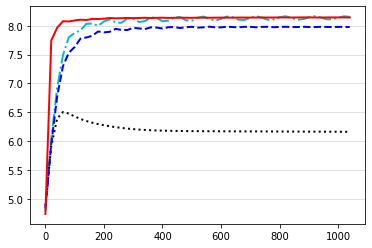

In [24]:
# plot reward values

f_value = plt.figure

num_every = 20
num_grads = np.arange(0, total_iterates, num_every)

reward_value = np.array(reward_value)
reward_value_reg = np.array(reward_value_reg)
reward_value_opt = np.array(reward_value_opt)
reward_value_pid = np.array(reward_value_pid)
# print(reward_value_opt)

plt.plot(num_grads,reward_value[::num_every], "c-.", linewidth=2)
plt.plot(num_grads,reward_value_pid[::num_every], "k:",linewidth=2)
plt.plot(num_grads,reward_value_reg[::num_every], "b--",linewidth=2)
plt.plot(num_grads,reward_value_opt[::num_every], "r-",linewidth=2)
plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
get_f_value.savefig('NPG_primal_dual_conserv_comparison_reward.png',dpi=300)

plt.show()

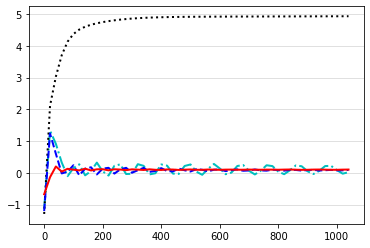

In [25]:
# plot utility values

g_value = plt.figure

num_every = 20
num_grads = np.arange(0, total_iterates, num_every)

utility_value = np.array(utility_value)
utility_value_reg = np.array(utility_value_reg)
utility_value_opt = np.array(utility_value_opt)
utility_value_pid = np.array(utility_value_pid)

plt.plot(num_grads,utility_value[::num_every], "c-.", linewidth=2)
plt.plot(num_grads,utility_value_pid[::num_every], "k:", linewidth=2)
plt.plot(num_grads,utility_value_reg[::num_every], "b--", linewidth=2)
plt.plot(num_grads,utility_value_opt[::num_every], "r-", linewidth=2)
plt.grid(axis='y', color='0.85')
plt.draw()
get_g_value = plt.gcf()
get_g_value.savefig('NPG_primal_dual_conserv_comparison_utility.png',dpi=300)

plt.show()